In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')

from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk, create_power_flux_fun

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          8905cc5
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/05/5bk04kj15rg64s4vd1hd6r0m0000gn/T/oft_42804/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)



**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.098E+00
    # of points  =    5677
    # of edges   =   16908
    # of cells   =   11232
    # of boundary points =     120
    # of boundary edges  =     120
    # of boundary cells  =     120
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  3.455E-02
    hmax =  1.152E-01
  Surface grounded at vertex    1537


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.9090000000000001E-003


In [5]:
coil_bounds = {key: [-1e11, 1e11] for key in mygs.coil_sets}
for key in [x for x in mygs.coil_sets if 'DIV' in x]:   
    coil_bounds[key] = [0, 0] # turn off div coils, for now
mygs.set_coil_bounds(coil_bounds)

In [6]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

## Define full scenario targets
To plan out a full pulse we now define representative time-dependent sequences for all required quantities. In this case we are just doing simple linear ramp-up and ramp-down of 10 ms each with a 40 ms flattop in between. We are assuming a 1 kA plasma after breakdown and are not including more detailed effects like flux consumption associated with breakdown. A simple density evolution is also defined to support evaluation of resistivity from the pressure profile.

In [7]:
# Define helper function for finding approximate limiting minor radius
lim_upper = np.flip(mygs.lim_contour[np.logical_and(mygs.lim_contour[:,0]>0.2,mygs.lim_contour[:,1]>0.06),:], axis=0)
def max_minor_rad(r0,kappa,delta,lim_pad=0.01):
    rmax = max(lim_upper[:,0])
    rmin = min(lim_upper[:,0])
    a_from_r = min(r0 - rmin, rmax - r0)
    r_zmax = r0 + a_from_r * np.cos(np.pi/2.0 + np.arcsin(delta))
    zmax_lim = scipy.interpolate.interp1d(lim_upper[:,0], lim_upper[:,1])(r_zmax) - lim_pad
    a_from_z = zmax_lim / kappa
    return min(a_from_z, a_from_r)

## READ DATA FROM MATLAB ##

In [8]:
import scipy.io as sio
# Function to load and reorganize .mat files into Python dictionaries
def load_mat_as_dict(filepath):
    #print(f"\nLoading file: {os.path.basename(filepath)}")
    raw_data = sio.loadmat(filepath)

    # Filter out MATLAB's internal metadata keys
    keys = [k for k in raw_data.keys() if not k.startswith("__")]

    data_dict = {}
    for k in keys:
        value = raw_data[k]
        # Convert numpy arrays with a single element to scalars
        if isinstance(value, np.ndarray):
            if value.shape == (1, 1):
                data_dict[k] = value.item()
            elif value.shape[0] == 1 and value.ndim == 2:
                data_dict[k] = value.flatten()
            else:
                data_dict[k] = value
        else:
            data_dict[k] = value

        #print(f"  - {k}: type={type(data_dict[k])}, shape={getattr(data_dict[k], 'shape', 'N/A')}")

    return data_dict

In [9]:
# Names
# 0 " I_{pl} [kA]            " 
# 1 " bet_{p}                "
# 2 " a [cm]                 "
# 3 " R [cm]                 "
# 4 " l_{i}(3)               "
# 5 " elong                  "
# 6 " rmag                   "
# 7 " zmag                   "
# 8 " N_{e} avr [20]         "
# 9 " Zeff                   "
# 10 " T_{e} avr [eV]        "
# 11 " T_{i} avr [eV]        "
# 12 " U ext                 "
# 13 " U res                 "
# 14 " VS ext                "
# 15 " VS res                "
# 16 " ves cur               "
# 17 " VS plas               "
# 18 " VS res                "
# 19 " VS ves                "
# 20 " VS pf                 "
# 21 " P_{ech}               "
# 22 " P_{oh}                "
# 23 " Tay_{e} [ms]          "

import numpy as np

def boxcar_smooth(data, window_size):
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, window, mode='same')
    return smoothed_data

data_zerod = load_mat_as_dict("zerod_params.mat")
time_zerod = np.transpose(data_zerod['time'] / 1e3)[0]
ip_zerod = data_zerod['simul_m'][:,0] * 1e3
betap_zerod = data_zerod['simul_m'][:,1]
a_zerod = data_zerod['simul_m'][:,2] / 1e2
R_zerod = data_zerod['simul_m'][:,3] / 1e2
kappa_zerod = data_zerod['simul_m'][:,5]
zmag_zerod = data_zerod['simul_m'][:,7] / 1e2
dens_zerod = data_zerod['simul_m'][:,8] * 1e20

vloop_zerod = boxcar_smooth(data_zerod['simul_m'][:,12],100)
flux_zerod = data_zerod['simul_m'][:,14]

In [10]:
scenario_targets = {
    'time': time_zerod,
    'Ip': ip_zerod,
    'kappa': kappa_zerod,
    'delta': np.ones_like(kappa_zerod)*-0.5,
    'r0': R_zerod,
    'z0': zmag_zerod,
    'beta_approx': betap_zerod ,
    'density': dens_zerod,
    'vloop': vloop_zerod,
    'psi': flux_zerod
}

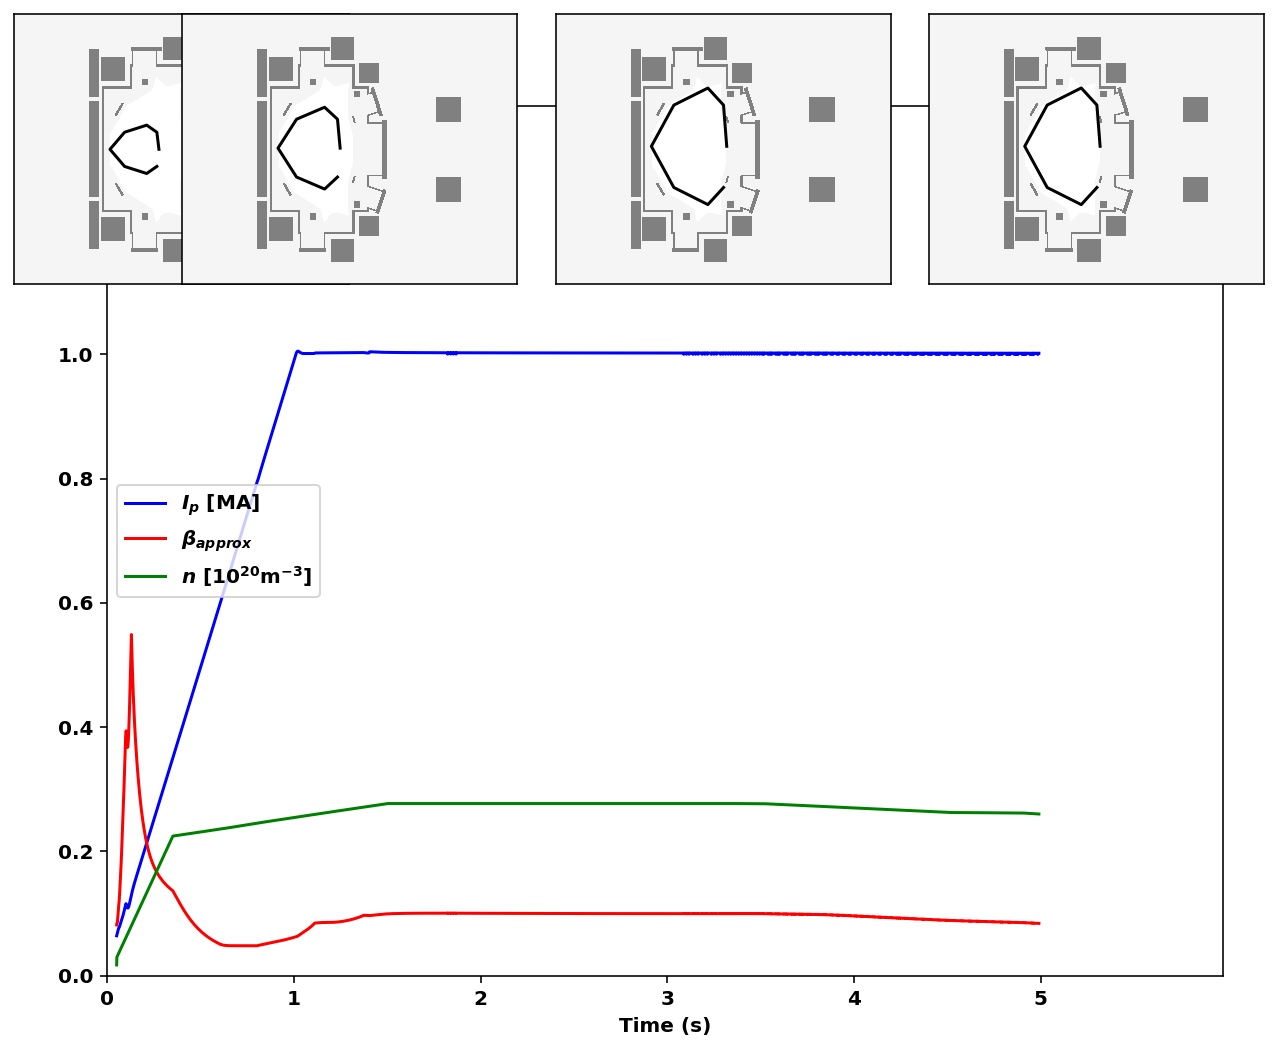

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(scenario_targets['time'],scenario_targets['Ip'] / 1.E6, c='b',label=r'$I_p$ [MA]')
ax.plot(scenario_targets['time'],scenario_targets['beta_approx'], c='r',label=r'$\beta_{approx}$')
ax.plot(scenario_targets['time'],scenario_targets['density'] / 1.E20, c='g',label=r'$n$ $[10^{20} $m$^{-3}]$')
t0 = 0#scenario_targets['time'][0] - 0.2*(scenario_targets['time'][-1] - scenario_targets['time'][0])
t1 = scenario_targets['time'][-1] + 0.2*(scenario_targets['time'][-1] - scenario_targets['time'][0])
ax.set_xlim(t0,t1)
ax.set_ylim(0,1.4)
ax.legend(loc='center left')
ax.set_xlabel('Time (s)')

t_plot = np.array([.100, 1, 3, 5])

a_minor = np.zeros_like(scenario_targets['time'])
for i, shot_time in enumerate(t_plot):
    rel_time = (shot_time-t0)/(t1-t0)
    inset_ax = ax.inset_axes([rel_time-.1, .75, .3, .4])
    mygs.plot_machine(fig, inset_ax, coil_colormap=None, limiter_color=None)
    r0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['r0'])
    z0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['z0'])
    kappa = np.interp(shot_time,scenario_targets['time'],scenario_targets['kappa'])
    delta = np.interp(shot_time,scenario_targets['time'],scenario_targets['delta'])
    a_minor[i] = a_current = max_minor_rad(r0,kappa,delta)
    isoflux_pts = create_isoflux(8, r0, z0, a_current, kappa, delta)
    inset_ax.plot(isoflux_pts[:,0], isoflux_pts[:,1], c='k')
    inset_ax.set_xticks([]); inset_ax.set_yticks([])

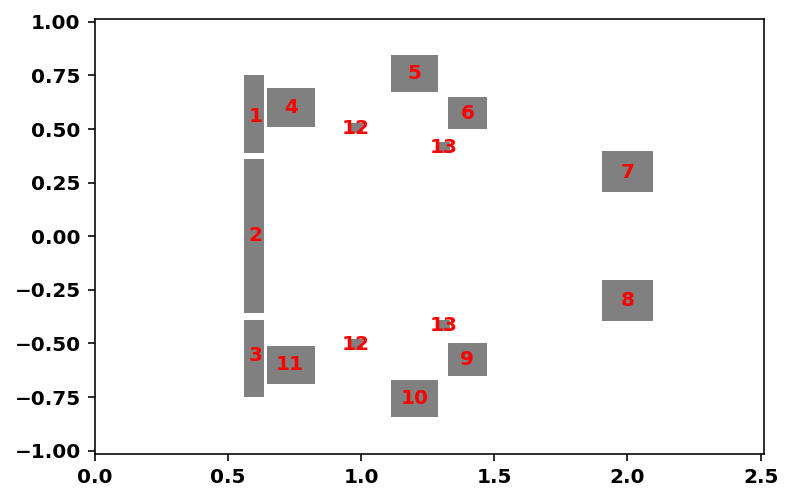

In [12]:
# Manual mapping to NSF outputs
coil_map = {
    'CS_1': 3,
    'CS_2': 2,
    'CS_3': 1,
    'PF_1U': 4,
    'PF_1L': 11,
    'PF_2U': 5,
    'PF_2L': 10,
    'PF_3U': 6,
    'PF_3L': 9,
    'PF_4U': 7,
    'PF_4L': 8,
    'DIV_1U': 12,
    'DIV_1L': 12,
    'DIV_2U': 13,
    'DIV_2L': 13,
}

mask_vals = np.ones((mygs.np,))
fix, ax = plt.subplots(1,1)
for _, coil_reg in mygs._coil_dict.items():
    mask_tmp = (mygs.reg == coil_reg['reg_id'])
    ax.tricontourf(mygs.r[:,0], mygs.r[:,1], mygs.lc[mask_tmp,:], mask_vals, colors='grey', alpha=1)
    
    # compute centroid of this coil region
    elems = mygs.lc[mask_tmp, :]

    # element centroids
    elem_centers_r = np.mean(mygs.r[elems, 0], axis=1)
    elem_centers_z = np.mean(mygs.r[elems, 1], axis=1)

    # region centroid = mean of element centroids
    r_center = np.mean(elem_centers_r)
    z_center = np.mean(elem_centers_z)
    
    # get coil name
    coil_name = next(
        name for name, coil in mygs.coil_sets.items()
        if any(sub['coil_id'] == coil_reg['coil_id'] for sub in coil['sub_coils'])
    )

    # place text in the center
    ax.text(r_center, z_center, coil_map[coil_name],
            ha='center', va='center', color='red', fontsize=10)


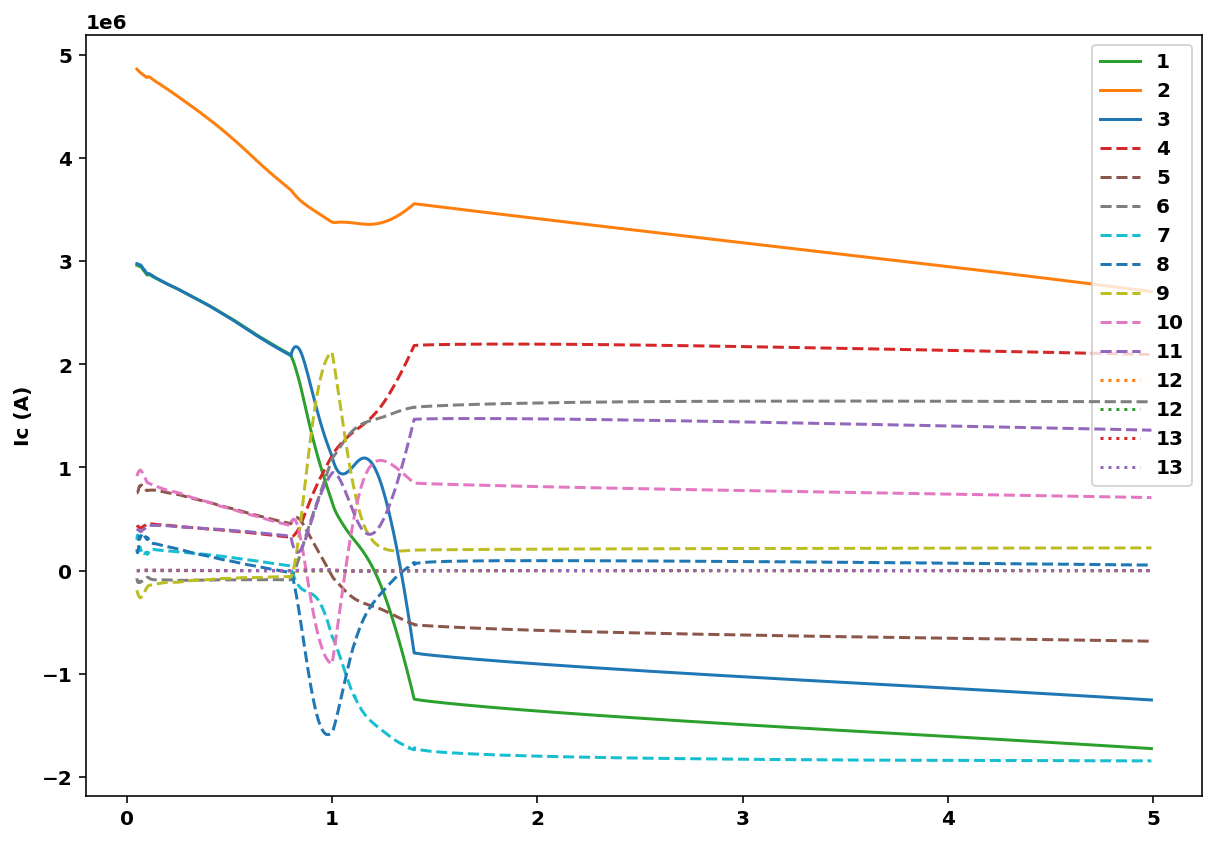

In [13]:
data_currents = load_mat_as_dict("currents_coils_cam.mat")
# Available variables (4): ['fc', 'icam', 't_cam', 't_fc']

fig, ax = plt.subplots(1,1, figsize=(10,7))

# Sort into coil_targets
coil_targets = {}
coil_names = mygs.coil_sets.keys()
coil_targets['time'] = data_currents['t_fc'] / 1e3
for coil_name in coil_names:
    coil_targets[coil_name] = data_currents['fc'][:,coil_map[coil_name]-1] * 1e3
    
    if coil_map[coil_name] > 11:
        ls = ':'
    elif coil_map[coil_name] > 3:
        ls = '--'
    else:
        ls = '-'
    ax.plot(coil_targets['time'], coil_targets[coil_name], label=coil_map[coil_name], zorder=coil_map[coil_name], ls=ls)
    
# Sort Legend
handles, labels = ax.get_legend_handles_labels()
legend_items = []
for handle, label in zip(handles, labels):
    if hasattr(handle, 'get_zorder'):
        zorder = handle.get_zorder()
    else:
        zorder = 0 # Default zorder if not found
    legend_items.append((zorder, handle, label))
legend_items.sort(key=lambda item: item[0])
sorted_handles = [item[1] for item in legend_items]
sorted_labels = [item[2] for item in legend_items]
ax.legend(sorted_handles, sorted_labels, loc=1)

ax.set_ylabel('Ic (A)')
plt.show()

In [14]:
coil_mirrors = {}
for name in coil_names:
    if 'U' in name:
        coil_mirrors[name] = name.replace('U','L')

## Same regmat for all (might be ambitious)
def set_regularization(gs_obj, time, weight_factor=1, updownsym=False, ignore=True):
    regularization_terms = []
    
    if ignore:
        for name, coil in mygs.coil_sets.items():
            if name not in coil_mirrors:
                continue        
            
            if 'CS' in name:
                regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=-3E6, weight=5))
                regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0}, target=0, weight=5))
            else:
                regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=0, weight=1))
                regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0}, target=0.0, weight=1.E1))
        
    else:
        for name, coil in mygs.coil_sets.items():
            if updownsym and name.find('L') >= 0: # We will set everything for upper coils
                continue
            if 'DIV' in name:
                regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E4))
                continue
            if 'PF' in name:
                #target = 0
                weight = 1.E-50
            else:
                weight = 1.E-1*weight_factor
            
            # Targets for normal coils and their mirror
            target = scipy.interpolate.interp1d(coil_targets['time'], coil_targets[name])(time)
            regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=target, weight=weight))
            if updownsym:
                regularization_terms.append(mygs.coil_reg_term({name: 1.0, name.replace('U','L'): -1.0}, target=0.0, weight=1.E1))

    # Pass regularization terms to TokaMaker
    gs_obj.set_coil_reg(reg_terms=regularization_terms)

In [15]:
# Compute new targets at current time
shot_time = scenario_targets['time'][-1000]

Ip = np.interp(shot_time,scenario_targets['time'],scenario_targets['Ip'])
beta_approx = np.interp(shot_time,scenario_targets['time'],scenario_targets['beta_approx']) 

mygs.set_targets(Ip=Ip,Ip_ratio=(1.0/beta_approx - 1.0))

r0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['r0'])
z0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['z0'])
kappa = np.interp(shot_time,scenario_targets['time'],scenario_targets['kappa'])
delta = np.interp(shot_time,scenario_targets['time'],scenario_targets['delta'])
density = np.interp(shot_time,scenario_targets['time'],scenario_targets['density'])
a_current = max_minor_rad(r0,kappa,delta)

isoflux_pts = create_isoflux(8, r0, z0, a_current, kappa, delta)
mygs.set_isoflux(isoflux_pts, weights=5.E2*np.ones_like(isoflux_pts[:,0]))

set_regularization(mygs, shot_time, ignore=True)


In [16]:
## SOLVE A TIME TO TEST ##

mygs.init_psi(0.68,0,0.2,1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  1.1944E+01  6.0388E-01  1.6275E-02  1.0326E+00  2.3169E-02 -0.0000E+00
     2  1.2997E+01  6.5879E-01  1.2402E-02  1.0323E+00  2.3464E-02 -0.0000E+00
     3  1.3299E+01  6.7553E-01  7.7466E-03  1.0320E+00  2.3670E-02 -0.0000E+00
     4  1.3398E+01  6.8150E-01  3.7953E-03  1.0318E+00  2.3819E-02 -0.0000E+00
     5  1.3430E+01  6.8375E-01  1.7473E-03  1.0316E+00  2.3924E-02 -0.0000E+00
     6  1.3440E+01  6.8464E-01  7.9954E-04  1.0314E+00  2.3996E-02 -0.0000E+00
     7  1.3444E+01  6.8501E-01  3.7579E-04  1.0314E+00  2.4044E-02 -0.0000E+00
     8  1.3445E+01  6.8518E-01  1.8588E-04  1.0313E+00  2.4076E-02 -0.0000E+00
     9  1.3445E+01  6.8526E-01  9.8238E-05  1.0313E+00  2.4097E-02 -0.0000E+00
    10  1.3445E+01  6.8531E-01  5.5617E-05  1.0313E+00  2.4110E-02 -0.0000E+00
    11  1.3446E+01  6.8534E-01  3.3406E-05  1.0313E+00  2.4119E-02 -0.0000E+00
    12  1.3446E+01  6.8536E-01  2.0956E-05  1.0313E+00  2.4125E-02 -0.0000E+00
    13  1.3446E+01  6.

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0020E+06
  Current Centroid [m]    =    1.018  0.024
  Magnetic Axis [m]       =    1.031  0.024
  Elongation              =    1.434 (U:  1.425, L:  1.443)
  Triangularity           =   -0.558 (U: -0.576, L: -0.540)
  Plasma Volume [m^3]     =    2.007
  q_0, q_95               =    0.864  1.602
  Plasma Pressure [Pa]    =   Axis:  4.7725E+04, Peak:  4.7725E+04
  Stored Energy [J]       =    4.3164E+04
  <Beta_pol> [%]          =    9.7907
  <Beta_tor> [%]          =    0.4050
  <Beta_n>   [%]          =    0.3177
  Diamagnetic flux [Wb]   =    1.7595E-02
  Toroidal flux [Wb]      =    9.3966E-01
  l_i                     =    0.9224
  psi_LCFS [mWb/rad]      =    9.106E+02


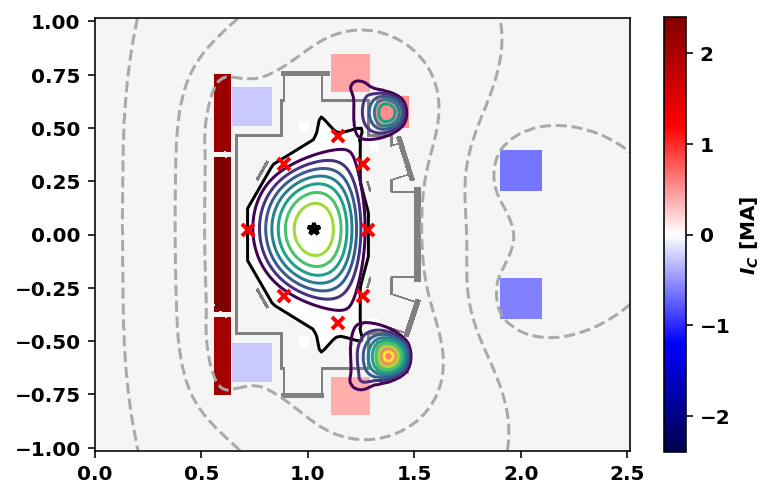

In [17]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
ax.plot(isoflux_pts[:,0], isoflux_pts[:,1], c='r', ls='', marker='x')

mygs.print_info()

lcfs_psi = mygs.psi_bounds[0]
print('  psi_LCFS [mWb/rad]      = {0:12.3E}'.format(lcfs_psi*1.E3))

## Compute initial post-breakdown equilibrium
To initialize our scenario we compute an initial post-breakdown equilibrium with a small circular, inboard-limited cross section. To achieve the longest possible pulse length we want to start the pulse with the higher possible flux on the LCFS, found here manually. Of course, this value depends on your current limits, which are just guesses for now.

0.08001000000000001
Starting non-linear GS solver
     1  1.7951E+01  3.4060E+00  3.7448E-02  8.8424E-01  3.3502E-03 -0.0000E+00
     2  5.6348E+00  1.0512E+00  5.1241E-03  8.8965E-01  2.4277E-03 -0.0000E+00
     3  4.3147E+00  7.9837E-01  1.4081E-03  8.9496E-01  1.4699E-03 -0.0000E+00
     4  3.8411E+00  7.0827E-01  1.0855E-03  8.9794E-01  9.5416E-04 -0.0000E+00
     5  3.6474E+00  6.7164E-01  6.3318E-04  8.9919E-01  6.9332E-04 -0.0000E+00
     6  3.5642E+00  6.5599E-01  3.2265E-04  8.9966E-01  5.8919E-04 -0.0000E+00
     7  3.5280E+00  6.4921E-01  1.5211E-04  8.9983E-01  5.4933E-04 -0.0000E+00
     8  3.5123E+00  6.4628E-01  6.8641E-05  8.9989E-01  5.3423E-04 -0.0000E+00
     9  3.5056E+00  6.4504E-01  3.0066E-05  8.9991E-01  5.2849E-04 -0.0000E+00
    10  3.5027E+00  6.4451E-01  1.2905E-05  8.9991E-01  5.2629E-04 -0.0000E+00
    11  3.5015E+00  6.4429E-01  5.4605E-06  8.9991E-01  5.2544E-04 -0.0000E+00
    12  3.5010E+00  6.4420E-01  2.2836E-06  8.9992E-01  5.2510E-04 -0.0000E+00
  

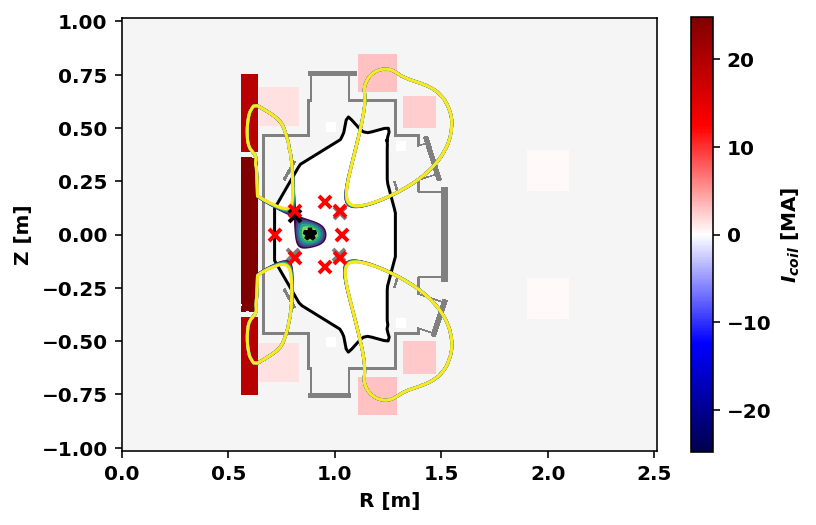

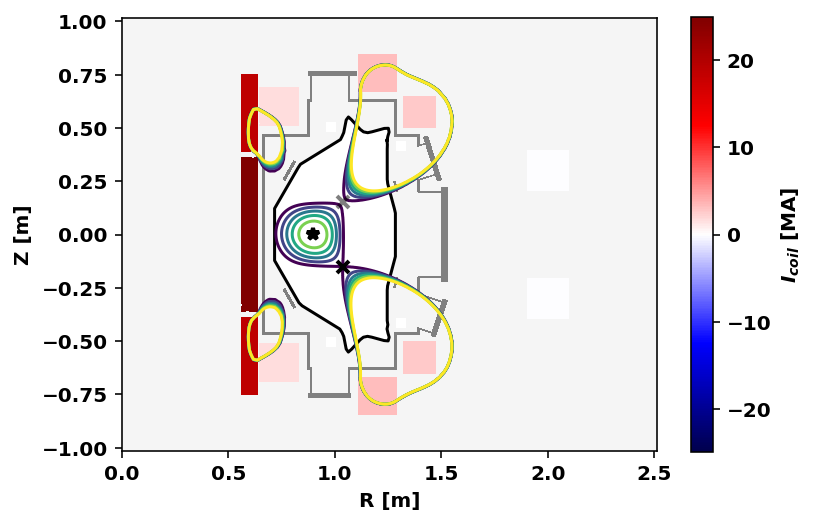

In [18]:
# Compute new targets at current time
shot_time = scenario_targets['time'][30]
print(shot_time)
start_time = shot_time * 1

Ip = np.interp(shot_time,scenario_targets['time'],scenario_targets['Ip'])
beta_approx = np.interp(shot_time,scenario_targets['time'],scenario_targets['beta_approx']) 

mygs.set_targets(Ip=Ip,Ip_ratio=(1.0/beta_approx - 1.0))

r0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['r0'])
z0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['z0'])
kappa = np.interp(shot_time,scenario_targets['time'],scenario_targets['kappa'])
delta = np.interp(shot_time,scenario_targets['time'],scenario_targets['delta'])
density = np.interp(shot_time,scenario_targets['time'],scenario_targets['density'])
a_current = max_minor_rad(r0,kappa,delta)

target_psi = np.interp(shot_time,scenario_targets['time'],scenario_targets['psi'])

isoflux_pts = create_isoflux(8, r0, z0, a_current, kappa, delta)
mygs.set_isoflux(isoflux_pts, weights=5.E2*np.ones_like(isoflux_pts[:,0]))
mygs.set_flux(isoflux_pts, target_psi*np.ones_like(isoflux_pts[:,0]), weights=1.E2*np.ones_like(isoflux_pts[:,0])) # Target specific flux value

set_regularization(mygs, shot_time, ignore=True)

mygs.init_psi(scenario_targets['r0'][0],0.0,0.2,1.0,0.0)

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-6,coil_clabel=r'$I_{coil}$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=0,plasma_nlevels=6)
ax.plot(isoflux_pts[:,0], isoflux_pts[:,1], c='r', ls='', marker='x')
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')

mygs.solve()

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-6,coil_clabel=r'$I_{coil}$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=0,plasma_nlevels=6)
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')

lcfs_psi = mygs.psi_bounds[0]
print('psi_LCFS = {0:12.3E} [mWb/rad]'.format(lcfs_psi*1.E3))

## Compute full pulse
Now we move on to compute equilibria throughout the full plasma pusled defined by the target waveforms above.

### Define resistivity helper functions
In order to capture the flux consumption we need to define resistivity in the plasma, which we do with a simple Spitzer model. Here we define simple helper models that map from the equilibrium pressure profile to a resistivity profile under the assumption of constant density and $T_e/T_i$.

In [19]:
def spitzer_resistivity(n,T):
    def log_lambda(n,T):
        return 24.0-np.log(np.sqrt(n/1.E6)/T)
    return 5.253E-5*log_lambda(n,T)/np.power(T,1.5)

def te_from_p(p,n,te_edge=100,ti_frac=1):
    from OpenFUSIONToolkit.util import eC
    total_temp = p/(n*eC)
    Te = total_temp/(1.0+ti_frac)
    return Te + te_edge

def coil_vec2dict(self,currents):
    current_array = np.zeros((self.ncoils,), dtype=np.float64)
    for coil_key, coil_current in currents.items():
        current_array[self.coil_sets[coil_key]['id']] = coil_current
    return current_array

0.095347 [V]


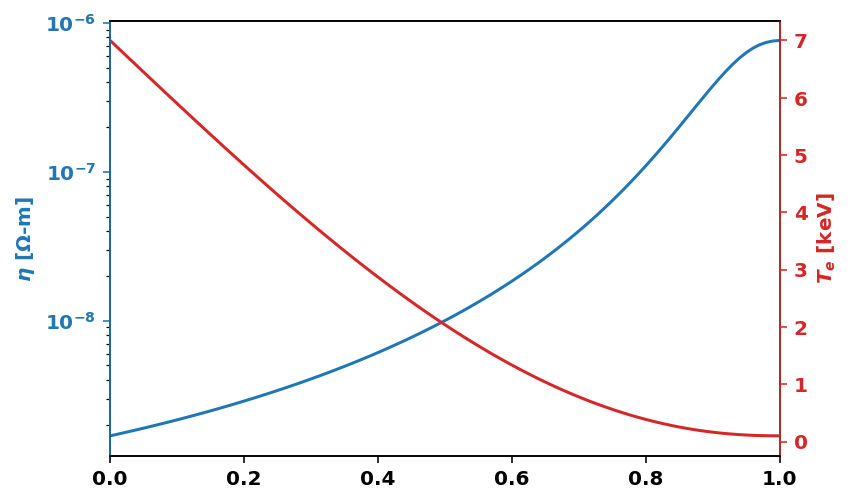

In [20]:
# Get temperature from pressure
psi_prof = np.linspace(0.0,1.0,100)
_,f,fp,p,pp = mygs.get_profiles(psi_prof)
density = scenario_targets['density'][0]
Te = te_from_p(p,density)
eta_prof = spitzer_resistivity(density,Te) # Spitzer resistivity

# Plot temperature and resistivity
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.semilogy(psi_prof,eta_prof,'tab:blue')
ax2.plot(psi_prof,Te/1e3,'tab:red')
ax.set_ylabel(r'$\eta$ [$\Omega$-m]',color='tab:blue')
ax2.set_ylabel(r'$T_e$ [keV]',color='tab:red')
ax.tick_params(axis='y',color='tab:blue', labelcolor='tab:blue')
ax2.tick_params(color='tab:red', labelcolor='tab:red')
ax2.spines['left'].set_edgecolor('tab:blue')
ax2.spines['right'].set_edgecolor('tab:red')
ax.set_xlim(0.0,1.0)

# Set resistivity and get loop voltage
mygs.set_resistivity({'type': 'linterp', 'x': psi_prof, 'y': eta_prof})
loop_voltage = mygs.calc_loopvoltage()
print('{0:.5} [V]'.format(loop_voltage))

### Compute equilibria
No we can compute equilibria through the pulse by stepping in time. At each point we compute a new equilibrium subject to the target constraints, including an time-varying value of $\psi_{LCFS}$ that is determined by the time-varying loop voltage computed using Spitzer resistivity. Additionally, we also apply a simple regularizatino term that aims to limit changes in coil current between time points, which is a simple proxy for minimizing coil voltages.

In [21]:
# Disable iteration printing in solve
mygs.settings.pm=False
mygs.update_settings()

# Initialize previous step values
prev_coils, _ = mygs.get_coil_currents()
psi_target = mygs.psi_bounds[0]
last_time = 0
dt = 0.2
nstatus = 1

# Create storage arrays for timeseries data
frames = []
psi_hist = [mygs.get_psi()]
coil_hist = [coil_vec2dict(mygs,prev_coils),]
flux_hist = [[mygs.psi_bounds[0],mygs.psi_bounds[0]],]
vloop_hist = [mygs.calc_loopvoltage()]
volt_hist = []
te0_hist = []
p0_hist = []
Lcoils = mygs.get_coil_Lmat()

# Run calculation over scenario
time_points = np.arange(start_time, scenario_targets['time'][-1], dt)
for step, shot_time in enumerate(time_points[1:]):
    # psi0 = mygs.get_psi(False)
    
    # Compute new global targets at current time
    Ip = np.interp(shot_time,scenario_targets['time'],scenario_targets['Ip'])
    beta_approx = np.interp(shot_time,scenario_targets['time'],scenario_targets['beta_approx']) 
    
    # Compute new shape targets at current time
    r0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['r0'])
    z0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['z0'])
    kappa = np.interp(shot_time,scenario_targets['time'],scenario_targets['kappa'])
    delta = np.interp(shot_time,scenario_targets['time'],scenario_targets['delta'])
    density = np.interp(shot_time,scenario_targets['time'],scenario_targets['density'])
    a_current = max_minor_rad(r0,kappa,delta)
    
    # Update LCFS target from loop voltage
    # dt = shot_time - last_time
    # delta_psi = (loop_voltage * dt) / (2 * np.pi)
    # psi_target -= delta_psi
    psi_target = np.interp(shot_time,scenario_targets['time'],scenario_targets['psi'])
    if step % nstatus == 0:
        print(f"Step {step:3d}: psi_target = {psi_target:.2E} Ip={Ip:.2E}, kappa={kappa:.2f}, delta={delta:.2f}, a={a_current:.3f}")
    
    # Set updated targets
    mygs.set_targets(Ip=Ip,Ip_ratio=(1.0/beta_approx - 1.0))
    isoflux_pts = create_isoflux(8, r0, z0, a_current, kappa, delta)
    mygs.set_flux(isoflux_pts, psi_target*np.ones((isoflux_pts.shape[0],)), weights=1.E2*np.ones_like(isoflux_pts[:,0]))
    mygs.set_isoflux(isoflux_pts, 3.E3*np.ones_like(isoflux_pts[:,0])) # By including isoflux pts too, we add weight to making sure the shape is matched in addition to the desired flux
    
    ignore_coil_inputs = True
    if ignore_coil_inputs:
        # Update coil regularization using coil currents from previous step
        regularization_terms = []
        for name, coil in mygs.coil_sets.items():   
            target = prev_coils[name]
            weight = 1.E-1
            
            regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=target, weight=weight))
        mygs.set_coil_reg(reg_terms=regularization_terms)
    else:
        set_regularization(mygs, shot_time, ignore=True)
        
    # # Try to force the x-points
    # if shot_time > flattop_start-2 and shot_time < flattop_end:
    #     mygs.set_saddles(x_points, x_weights*10)
    # else:
    #     mygs.set_saddles(None, None)
    
    # Solve for next equilibrium
    try:
        # mygs.set_psi_dt(psi0,dt) # Set previous equilibrium as reference for eddy currents
        mygs.solve()
    except Exception as e:
        print("  WARNING: Step failed, {0}".format(str(e)))

    # Compute coil voltages
    coil_currents, _ = mygs.get_coil_currents()
    volt_hist.append(np.dot(Lcoils[:-1,:-1],coil_vec2dict(mygs,coil_currents)-coil_vec2dict(mygs,prev_coils))/dt)

    # Save coil currents and boundary flux
    prev_coils = coil_currents.copy()
    coil_hist.append(coil_vec2dict(mygs,coil_currents))
    flux_hist.append([psi_target,mygs.psi_bounds[0]])
    psi_hist.append(mygs.get_psi())
    
    # Update temperature, resistivity, and loop voltage
    psi_prof = np.linspace(0.0, 1.0, 100)
    _, f, fp, p, pp = mygs.get_profiles(psi_prof)
    Te = te_from_p(p, density)
    eta_prof = spitzer_resistivity(density, Te)
    mygs.set_resistivity({'type': 'linterp', 'x': psi_prof, 'y': eta_prof})
    loop_voltage = mygs.calc_loopvoltage()
    te0_hist.append(Te[0])
    p0_hist.append(p[0])
    vloop_hist.append(loop_voltage)
    
    # Update previous time step
    last_time = shot_time
    
    # Create frame for animation
    fig, ax = plt.subplots(dpi=300,tight_layout=True)
    mygs.plot_machine(fig, ax, coil_colormap='seismic', coil_symmap=True, coil_scale=1e-3, coil_clabel=r'$I_{coil}$ [kA]', limiter_color=None)
    mygs.plot_psi(fig, ax, xpoint_color='k', vacuum_nlevels=0, plasma_nlevels=6)
    ax.plot(isoflux_pts[:, 0], isoflux_pts[:, 1], color='tab:red', label="Target LCFS")
    ax.set_title(r'$I_p$ ={0:4.0F} kA, $V_{{\phi}}$ ={1:4.2F} V, $t$ ={2:4.0F} ms'.format(Ip/1.E3,loop_voltage,shot_time*1.E3))
    ax.legend()
    ax.set_ylabel('Z [m]')
    ax.set_xlabel('R [m]')
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(image)
    plt.close(fig)

# Reenable iteration plotting 
mygs.settings.pm=True
mygs.update_settings()

Step   0: psi_target = 7.24E+00 Ip=2.81E+05, kappa=1.00, delta=-0.50, a=0.200
Step   1: psi_target = 6.53E+00 Ip=4.77E+05, kappa=1.00, delta=-0.50, a=0.209
Step   2: psi_target = 5.73E+00 Ip=6.74E+05, kappa=1.00, delta=-0.50, a=0.218
Step   3: psi_target = 5.00E+00 Ip=8.72E+05, kappa=1.13, delta=-0.50, a=0.227
Step   4: psi_target = 4.56E+00 Ip=1.00E+06, kappa=1.41, delta=-0.50, a=0.241
Step   5: psi_target = 4.41E+00 Ip=1.00E+06, kappa=1.52, delta=-0.50, a=0.268
Step   6: psi_target = 4.28E+00 Ip=1.00E+06, kappa=1.55, delta=-0.50, a=0.283
Step   7: psi_target = 4.20E+00 Ip=1.00E+06, kappa=1.55, delta=-0.50, a=0.283
Step   8: psi_target = 4.12E+00 Ip=1.00E+06, kappa=1.55, delta=-0.50, a=0.283
Step   9: psi_target = 4.04E+00 Ip=1.00E+06, kappa=1.55, delta=-0.50, a=0.283
Step  10: psi_target = 3.97E+00 Ip=1.00E+06, kappa=1.55, delta=-0.50, a=0.283
Step  11: psi_target = 3.89E+00 Ip=1.00E+06, kappa=1.55, delta=-0.50, a=0.283
Step  12: psi_target = 3.81E+00 Ip=1.00E+06, kappa=1.55, delta=-

### Plot shape evolution


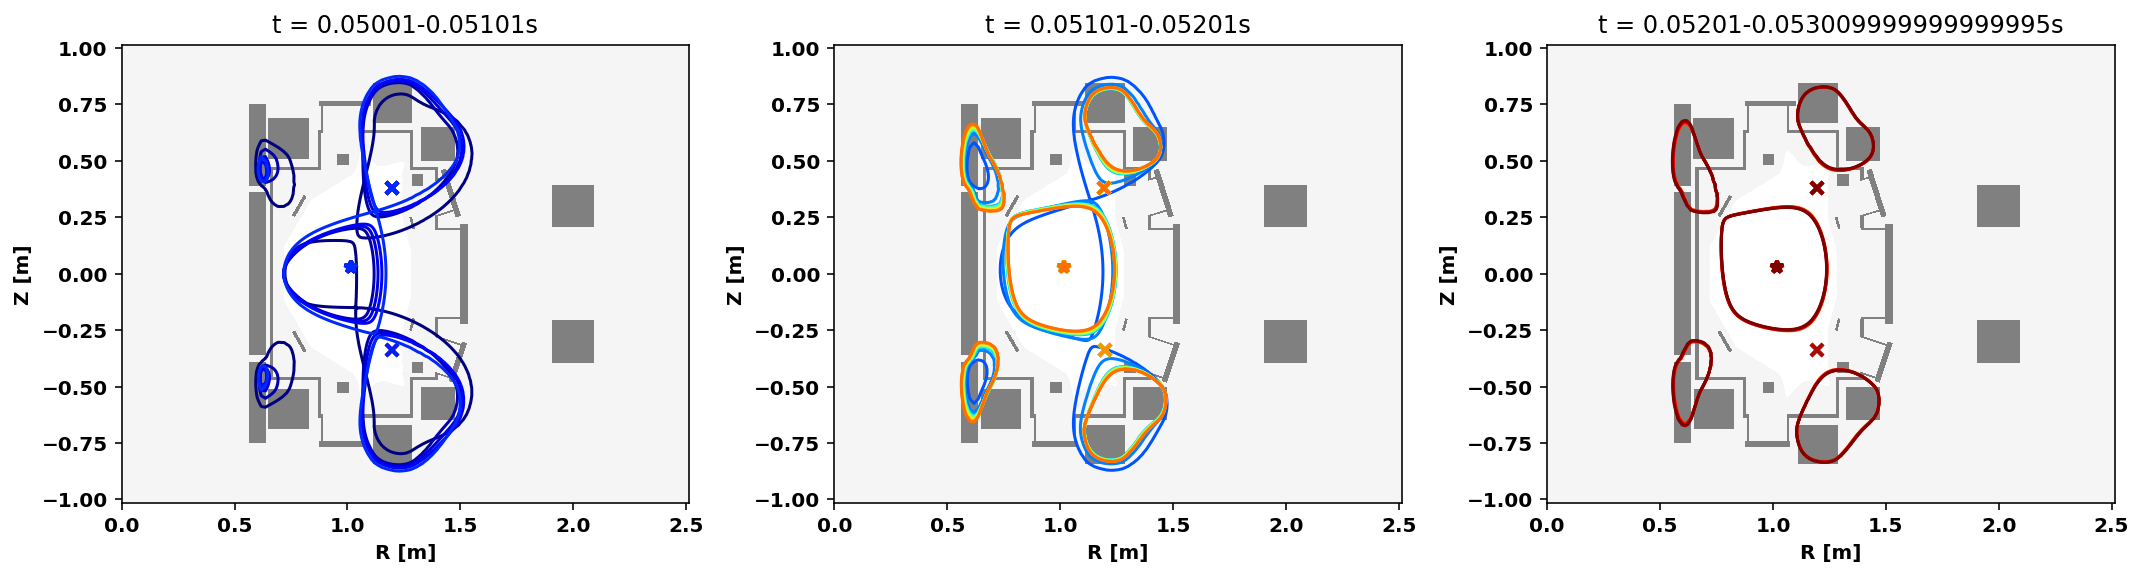

In [22]:
# plot evolution of flux surfaces

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for ax in axs:  
    mygs.plot_machine(fig,ax,limiter_color=None)
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(psi_hist)))
x=np.linspace(0.0,2*np.pi,100)
for i, result in enumerate(psi_hist):
    t = time_points[i]
    if t<1: ax = axs[0]
    elif t<4: ax = axs[1]
    else: ax = axs[2]
    
    try:
        mygs.plot_psi(fig,ax,psi=result,plasma_levels=[1.0],plasma_color=[colors[i]],vacuum_nlevels=0,xpoint_color=colors[i],opoint_color=colors[i])
    except Exception:
        print(i)
        pass
        
for i,ax in enumerate(axs):
    ax.set_xlabel('R [m]')
    ax.set_ylabel('Z [m]')
    ax.set_title(f"t = {scenario_targets['time'][i]}-{scenario_targets['time'][i+1]}s")
    
plt.tight_layout()    
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


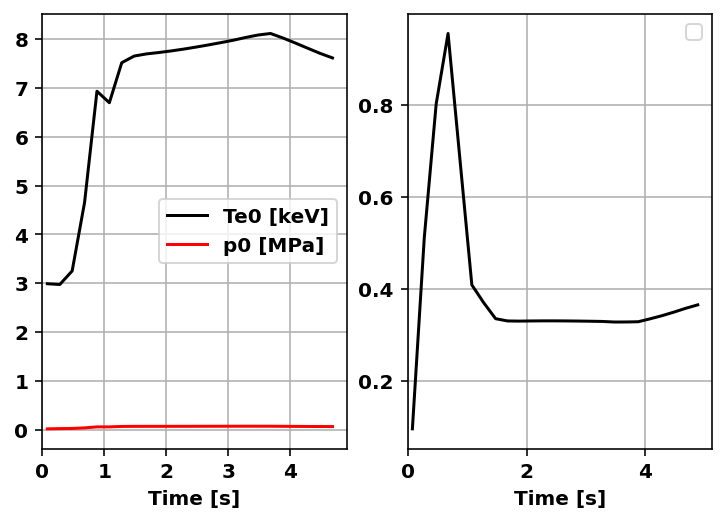

In [23]:
# plot profiles

te0_hist = np.array(te0_hist)
p0_hist = np.array(p0_hist)
vloop_hist = np.array(vloop_hist)

fig, axs = plt.subplots(1,2)
axs[0].plot(time_points[:len(te0_hist)],te0_hist/1e3,'k',label=r'Te0 [keV]')
axs[0].plot(time_points[:len(p0_hist)],p0_hist/1e6,'r',label=r'p0 [MPa]')
axs[0].grid(True)
axs[0].set_xlim(left=0.0)
axs[0].set_xlabel('Time [s]')

axs[1].plot(time_points[:len(vloop_hist)],vloop_hist,'k',label=r'')
axs[1].grid(True)
axs[1].set_xlim(left=0.0)
axs[1].set_xlabel('Time [s]')

_ = axs[0].legend()
_ = axs[1].legend()

### Compare target and realized $\psi_{LCFS}$

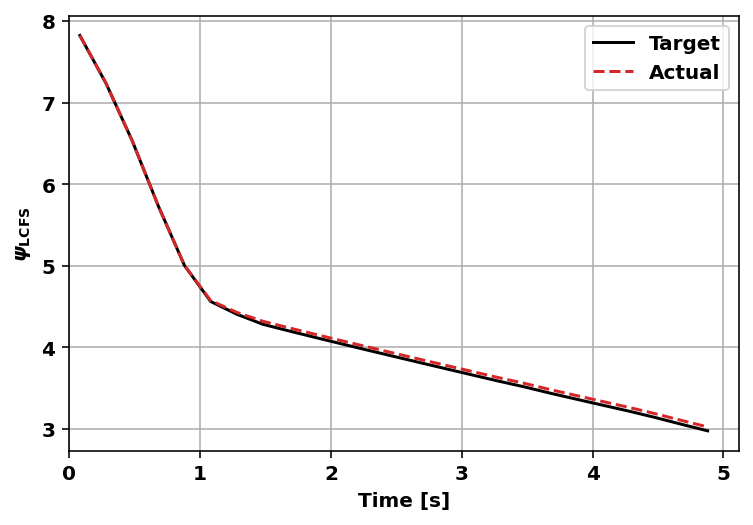

In [24]:
flux_hist = np.array(flux_hist)
fig, ax = plt.subplots(1,1)
ax.plot(time_points[:len(flux_hist[:,0])],flux_hist[:,0],'k',label=r'Target')
ax.plot(time_points[:len(flux_hist[:,0])],flux_hist[:,1],'--',color='tab:red',label=r'Actual')
ax.grid(True)
ax.set_xlim(left=0.0)
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$\psi_\mathrm{LCFS}$')
_ = ax.legend()

### Plot coil currents

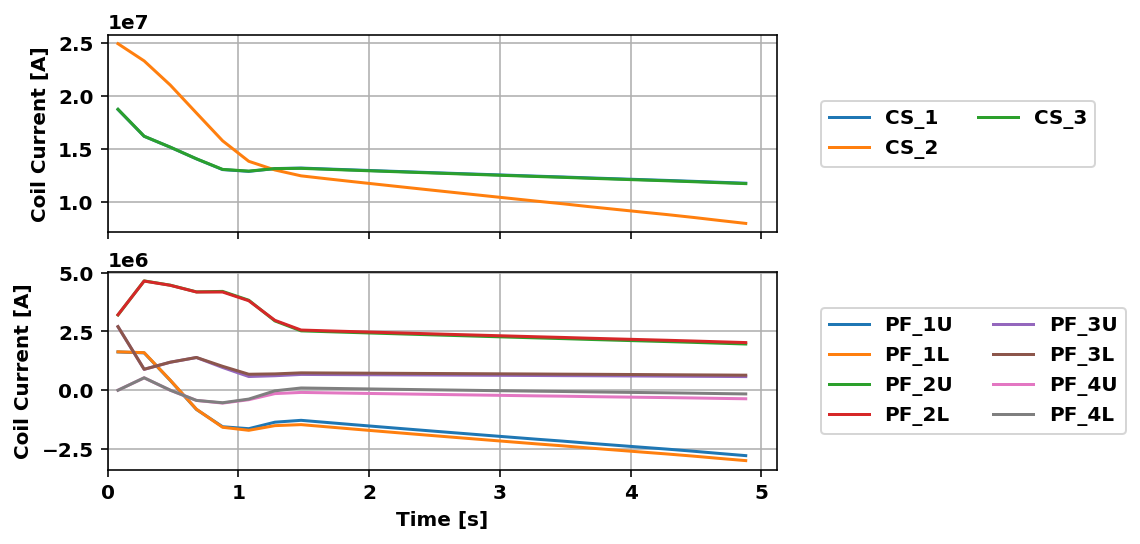

In [25]:
coil_hist = np.array(coil_hist)
fig, ax = plt.subplots(2,1,sharex=True)
for name, coil in mygs.coil_sets.items():
    if name.startswith('CS'):
        ax[0].plot(time_points[:len(coil_hist[:,0])],coil_hist[:,coil['id']],label=name)
    if name.startswith('PF'):
        ax[1].plot(time_points[:len(coil_hist[:,0])],coil_hist[:,coil['id']],label=name)
for ax_tmp in ax:
    ax_tmp.grid(True)
    ax_tmp.set_xlim(left=0.0)
    ax_tmp.set_ylabel('Coil Current [A]')
    ax_tmp.legend(ncols=2,loc='center left',bbox_to_anchor=(1.05, 0.5))
_ = ax[-1].set_xlabel('Time [s]')

### Plot coil voltages

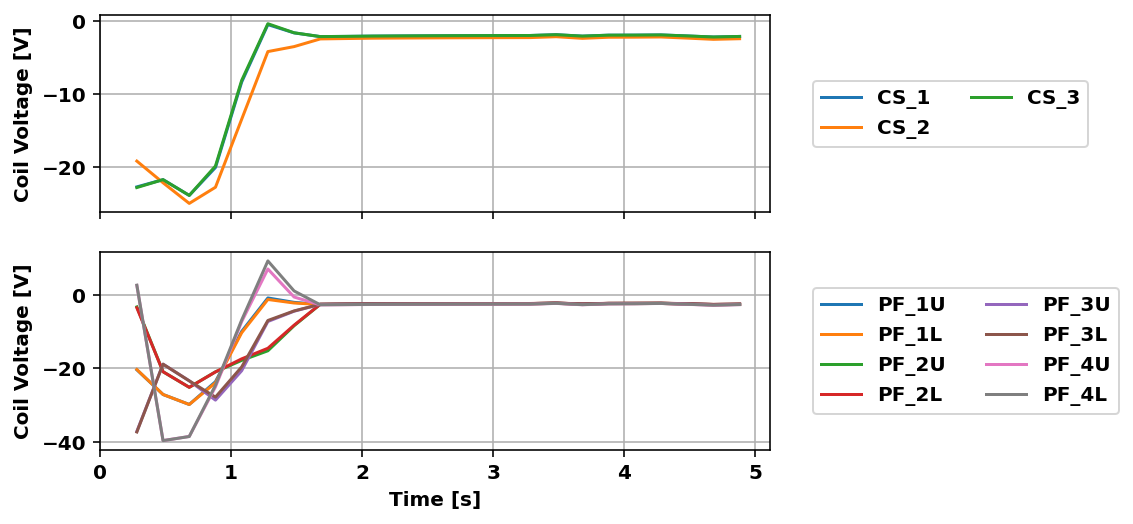

In [26]:
volt_hist = np.array(volt_hist)
fig, ax = plt.subplots(2,1,sharex=True)
for name, coil in mygs.coil_sets.items():
    if name.startswith('CS'):
        ax[0].plot(time_points[1:],volt_hist[:,coil['id']],label=name)
    if name.startswith('PF'):
        ax[1].plot(time_points[1:],volt_hist[:,coil['id']],label=name)
for ax_tmp in ax:
    ax_tmp.grid(True)
    ax_tmp.set_xlim(left=0.0)
    ax_tmp.set_ylabel('Coil Voltage [V]')
    ax_tmp.legend(ncols=2,loc='center left',bbox_to_anchor=(1.05, 0.5))
_ = ax[-1].set_xlabel('Time [s]')